<a href="https://colab.research.google.com/github/TharukaGamage19/CM2604-Cousework_2425604_Tharuka/blob/main/CM2606_Coursework_Tharuka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

## **1.1 Project Overview**
Customer attrition, widely referred to as "churn," represents a critical operational metric within the telecommunications sector. Economic theory suggests that the capital expenditure required to acquire a new customer significantly exceeds the cost of retaining an existing one. Consequently, the development of predictive mechanisms to identify at-risk customers allows organizations to implement targeted retention strategies, thereby preserving revenue streams.

## **1.2 Objective**
The primary objective of this study is to perform a binary classification task to predict customer churn. The scope includes:
1.  **Corpus Preparation:** The construction of a robust, balanced, and numeric dataset suitable for algorithmic training.
2.  **Exploratory Data Analysis (EDA):** A statistical investigation to uncover latent patterns and drivers of attrition.
3.  **Model Implementation:** The comparative analysis of a **Decision Tree Classifier** (symbolic learning) and an **Artificial Neural Network** (connectionist learning).
4.  **Critical Evaluation:** The assessment of model performance using industry-standard metrics to determine the optimal solution for deployment.


# **2. Understanding Data**

Prior to the application of preprocessing techniques, an initial investigation of the raw dataset was conducted. This phase focuses on assessing data integrity, attribute types, and statistical distributions to inform the subsequent corpus preparation strategy.

## **2.1 Overview of the Dataset**
The "Telco Customer Churn" dataset, sourced from Kaggle, was utilized for this analysis.
* **Target Variable:** `Churn` (Nominal: Yes/No).
* **Feature Space:** The dataset comprises customer demographics (e.g., Gender, Senior Citizen status), subscribed services (e.g., Internet, Phone), and account information (e.g., Contract type, Charges).

### **2.1.1 Library Justification**
The following Python libraries were selected for this study:
* **`kagglehub`**: Utilized for programmatic data ingestion, ensuring the latest dataset version is retrieved directly from the source.
* **`pandas`**: Selected for its efficient DataFrame object, enabling high-performance data manipulation and structural analysis.
* **`numpy`**: Used for high-level mathematical functions and array operations required during data transformation.
* **`matplotlib` & `seaborn`**: Chosen for their comprehensive data visualization capabilities, essential for EDA.
* **`scikit-learn`**: The industry-standard library for machine learning, providing tools for preprocessing, model development (Decision Trees), and metric evaluation.
* **`tensorflow` (Keras)**: Selected for constructing the Artificial Neural Network due to its flexibility in defining deep learning architectures.

In [53]:
#libraries n configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

# Configuration for readability
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')


print("Initiating dataset download via KaggleHub...")
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"Dataset successfully loaded. Dimensions: {df.shape}")

Initiating dataset download via KaggleHub...
Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Dataset successfully loaded. Dimensions: (7043, 21)


## **2.2 Structural Analysis and Distribution**
The dataset dimensions and attribute data types were examined to identify potential anomalies.

In [54]:
#first 5 instances to assess data structure
display(df.head())

# Inspecting data types and non-null counts
print("\n***Feature Data Types and Integrity***\n")
df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



***Feature Data Types and Integrity***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

### **General Structure**
1.  **Dimensionality:** The dataset consists of 7,043 observations and 21 attributes.
2.  **Attribute Types:** The majority of features are categorical (`object`). Only `SeniorCitizen`, `tenure`, and `MonthlyCharges` were initially recognized as numeric.
3.  **Data Type Anomaly:** It was observed that `TotalCharges` is encoded as an `object` (string) type. Given that this feature represents a cumulative financial metric, it should structurally be a float. This indicates the presence of non-numeric characters (likely empty strings) that require correction.

## **2.3 Data Integrity and Distribution**
The dataset was further assessed for duplicates, missing values, and class balance.

In [55]:
#Duplicate Detection
duplicates = df.duplicated().sum()
print(f"Duplicate Rows Detected: {duplicates}")

#Missing Value Analysis (Raw)
print("\n--- Missing Values (Standard Check) ---")
print(df.isnull().sum())


Duplicate Rows Detected: 0

--- Missing Values (Standard Check) ---
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


1.  **Duplicates:** No full-row duplicates were identified, indicating a unique set of customer records.
2.  **Missing Values:** Standard checks returned zero null values. However, the type anomaly in `TotalCharges` suggests latent missing data that must be addressed during corpus preparation.

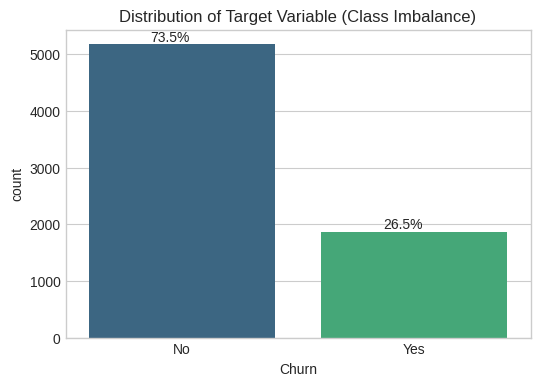

In [56]:
#Target Variable Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df, palette='viridis')
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.title('Distribution of Target Variable (Class Imbalance)')
plt.show()

A significant imbalance was observed in the target variable. Approximately **73.4%** of the dataset represents retained customers, while **26.6%** represents churned customers. This skew suggests that accuracy alone will be an insufficient metric for evaluation. Furthermore, without intervention (balancing), predictive models may become biased toward the majority class.

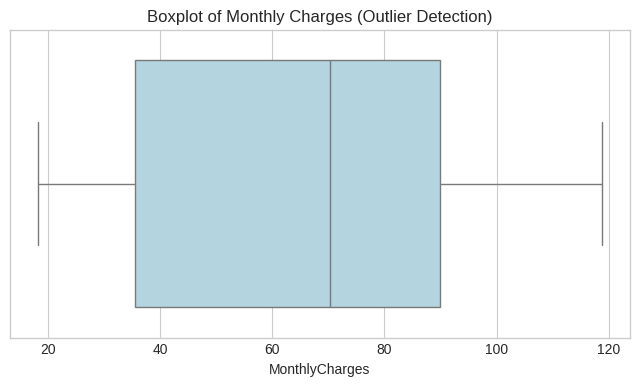

In [57]:
#Outlier Detection (Initial Observation)
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['MonthlyCharges'], color='lightblue')
plt.title('Boxplot of Monthly Charges (Outlier Detection)')
plt.show()

 The boxplot for `MonthlyCharges` does not reveal extreme outliers, suggesting the financial data is within a reasonable range for telecommunication services.

# **3. Corpus Preparation**

A machine learning corpus is defined as a collection of authentic data organized into datasets for algorithm training. To ensure valid experimental results, a rigorous preparation pipeline was implemented to transform the raw data into a **clean**, **numeric**, and **balanced** corpus.

## **3.1 Data Cleaning**
To rectify data quality issues identified during the understanding phase, data cleaning process was done. The `TotalCharges` column contained empty strings (`" "`) for customers with zero tenure. These were coerced to numeric values (NaN) and subsequently removed. The `customerID` column was dropped as it functions as a database key with no predictive variance.

In [58]:

#Coerce TotalCharges to numeric n converting empty str to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Handle missing values
missing_val = df['TotalCharges'].isnull().sum()
print(f"Latent missing values identified in TotalCharges: {missing_val}")
df.dropna(subset=['TotalCharges'], inplace=True)

#Remove non predictive identifier
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

print(f"Data Cleaning Complete. Current Corpus Dimensions: {df.shape}")

Latent missing values identified in TotalCharges: 11
Data Cleaning Complete. Current Corpus Dimensions: (7032, 20)


## **3.2 Feature Engineering**
The objective of this section is to synthesize new features that capture broader patterns in the data.
A new feature, `Tenure_Group`, was created by binning the continuous `tenure` variable into categorical lifecycle stages ('New', 'Developing', 'Established', 'Loyal'). This transformation aids decision tree algorithms in generalizing rules (e.g., "New customers are high risk") rather than overfitting to specific integer values of tenure.

In [59]:
def tenure_group(t):
    if t <= 12: return 'New'
    elif t <= 24: return 'Developing'
    elif t <= 48: return 'Established'
    else: return 'Loyal'

df['Tenure_Group'] = df['tenure'].apply(tenure_group)
print("Feature 'Tenure_Group' successfully synthesized.")

Feature 'Tenure_Group' successfully synthesized.


## **3.3 Encoding and Transformation**
An encoding process was done to convert categorical text data into a numerical format interpretable by machine learning algorithms.

1.   **Label Encoding:** Applied to binary variables (e.g., `Partner`, `PhoneService`) to map them to scalars (0 and 1).
2.   **One-Hot Encoding:** Applied to multi-class nominal variables (e.g., `InternetService`, `PaymentMethod`). This creates orthogonal binary vectors, preventing the model from inferring false ordinal relationships between categories.





In [60]:
from sklearn.preprocessing import LabelEncoder

#labl encoding
le = LabelEncoder()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

#One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

print(f"Encoding Complete. Feature space expanded to {df.shape[1]} dimensions.")

Encoding Complete. Feature space expanded to 34 dimensions.


## **3.4 Feature Scaling**
 Neural Networks utilize Gradient Descent for optimization. If input features possess vastly different scales (e.g., `tenure` $\approx$ 70 vs `TotalCharges` $\approx$ 8000), the error surface becomes elongated, causing the gradient descent algorithm to oscillate and delaying convergence. **Min-Max Scaling** was applied to `tenure`, `MonthlyCharges`, and `TotalCharges` to ensure a spherical error surface and efficient training.

In [61]:
#Scaling
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print("Continuous features successfully scaled to range [0, 1].")

Continuous features successfully scaled to range [0, 1].


## **3.5 Handling Class Imbalance (SMOTE)**

As noted in the Section 2.3 (Target class Distribution), the dataset was heavily imbalanced. To construct a balanced corpus suitable for training sensitive algorithms like Neural Networks, **SMOTE (Synthetic Minority Over-sampling Technique)** was applied. Rather than simply duplicating existing minority class examples (which leads to overfitting), SMOTE synthesizes new examples by interpolating between existing minority instances in the feature space. The corpus was transformed from a 73:27 distribution to a 50:50 distribution, ensuring equal representation of Churn and Retention classes.

In [62]:
# corpus balancing (SMOTE)
from imblearn.over_sampling import SMOTE

X = df.drop('Churn', axis=1)
y = df['Churn']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original Class Distribution: {y.value_counts().to_dict()}")
print(f"Balanced Class Distribution: {y_resampled.value_counts().to_dict()}")

Original Class Distribution: {0: 5163, 1: 1869}
Balanced Class Distribution: {0: 5163, 1: 5163}


The data has been successfully cleaned, enriched, numerically encoded, scaled, and balanced. This processed corpus serves as the foundation for the subsequent Exploratory Data Analysis and Model Implementation phases.

# **4. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) was conducted on the processed corpus to elucidate the underlying statistical properties and relational structures within the data. This analytical phase serves to validate hypotheses regarding customer attrition drivers and to verify that the feature engineering process successfully captured meaningful signal patterns. By systematically examining distributions, correlations, and multivariate interactions, the study establishes a data-driven foundation for the subsequent modeling phase.

## **4.1 Correlation Analysis**
To quantify the linear relationships between all variables in the feature space, a comprehensive correlation analysis was performed using a Heatmap. This visualization provides a macroscopic view of the dataset, where each cell represents the correlation coefficient between two variables. This is crucial for:
1.  **Identifying Drivers:** Observing which features (rows) have a strong color intensity relative to the `Churn` column.
2.  **Detecting Multicollinearity:** Identifying feature pairs (e.g., `TotalCharges` and `MonthlyCharges`) that are highly correlated with each other, which can introduce redundancy into the model.

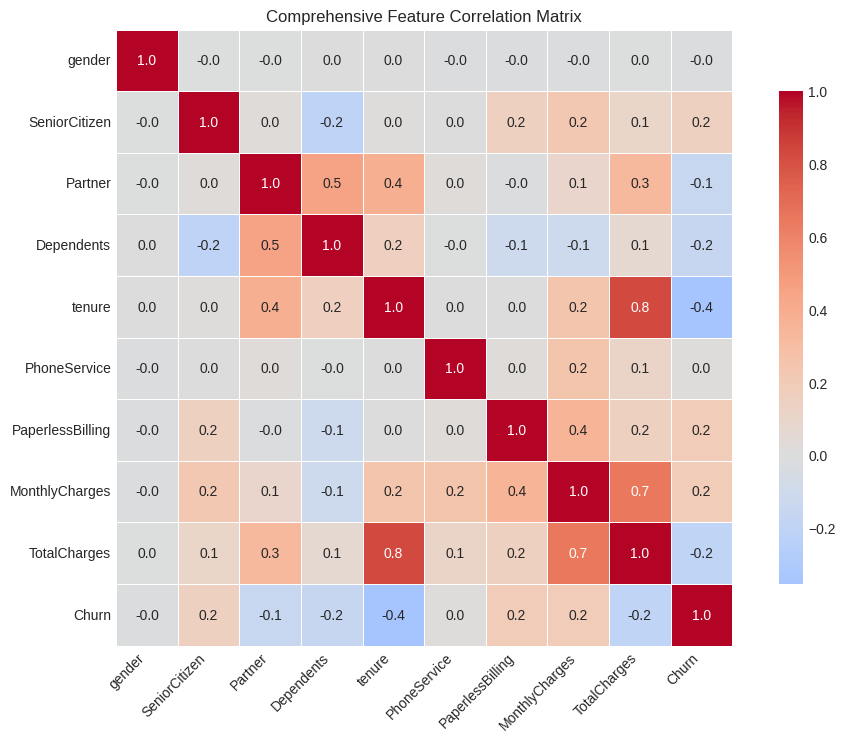

In [63]:
# --- CORRELATION ANALYSIS (FULL SQUARE HEATMAP) ---
plt.figure(figsize=(12, 8))

# 1. Select only numeric columns to avoid errors with categorical 'Tenure_Group'
numeric_df = df.select_dtypes(include=[np.number])

# 2. Calculate the full correlation matrix (N x N)
corr_matrix = numeric_df.corr()

# 3. Generate the Square Heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',    # Red = Positive, Blue = Negative
            center=0,           # Center the colormap at 0
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Comprehensive Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

The heatmap provides a comprehensive visual summary of the dataset's internal structure.
* **Target Correlations:** Inspecting the `Churn` column (or row) reveals that `Contract_Month-to-month` and `InternetService_Fiber optic` have strong positive correlations (indicated by red tiles), identifying them as primary risk factors. Conversely, `tenure` and `Contract_Two year` show deep blue tiles, confirming them as strong retention factors.
* **Multicollinearity:** A significant positive correlation ($>0.8$) is observed between `MonthlyCharges` and `Fiber Optic` service, as well as between `tenure` and `TotalCharges`. This expected redundancy suggests that while both features contain signal, Neural Networks may benefit from this dense information, whereas simple linear models might require feature selection.

## **4.2 Financial Distribution Analysis**
Financial factors are frequently cited in economic literature as primary drivers of consumer behavior. Therefore, an investigation into the distribution of `MonthlyCharges` and `TotalCharges` was conducted to assess price sensitivity. Kernel Density Estimation (KDE) plots were utilized to visualize the probability density of these continuous variables, enabling a comparative analysis of distribution shapes between churned and retained customer cohorts.

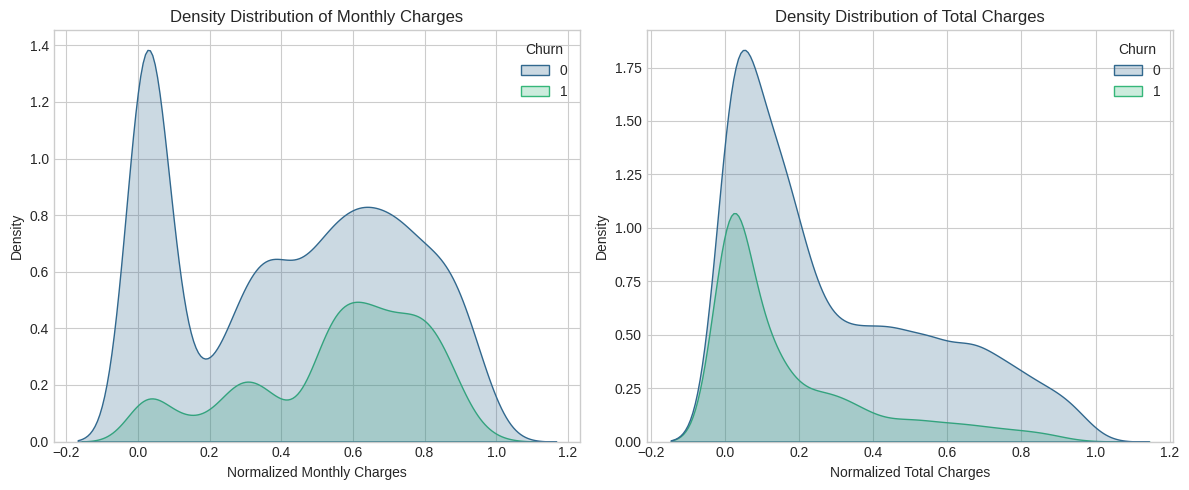

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# KDE Plot for Monthly Charges
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette='viridis', ax=ax[0])
ax[0].set_title('Density Distribution of Monthly Charges')
ax[0].set_xlabel('Normalized Monthly Charges')

# KDE Plot for Total Charges
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, palette='viridis', ax=ax[1])
ax[1].set_title('Density Distribution of Total Charges')
ax[1].set_xlabel('Normalized Total Charges')

plt.tight_layout()
plt.show()

The density plots illustrate a clear divergence in financial profiles. The `MonthlyCharges` distribution for churned customers is heavily skewed towards the upper quartile, indicating that customers with larger monthly financial obligations are disproportionately more likely to cancel their service. In contrast, the `TotalCharges` distribution reveals that churned customers tend to have lower accumulated lifetime value. When synthesized with the correlation data, this implies that churn typically occurs early in the customer lifecycle before significant total charges can be accrued, highlighting the critical nature of the onboarding period for retention efforts.

## **4.3 Multivariate Analysis: Tenure vs. Cost**
To further investigate the interaction between customer longevity and financial burden, a multivariate scatter analysis was performed. This visualization aims to determine if specific clusters of at-risk customers emerge when observing `Tenure` and `MonthlyCharges` simultaneously. Understanding these interaction effects is crucial, as non-linear models like Neural Networks excel at exploiting such combinatory patterns to define complex decision boundaries.

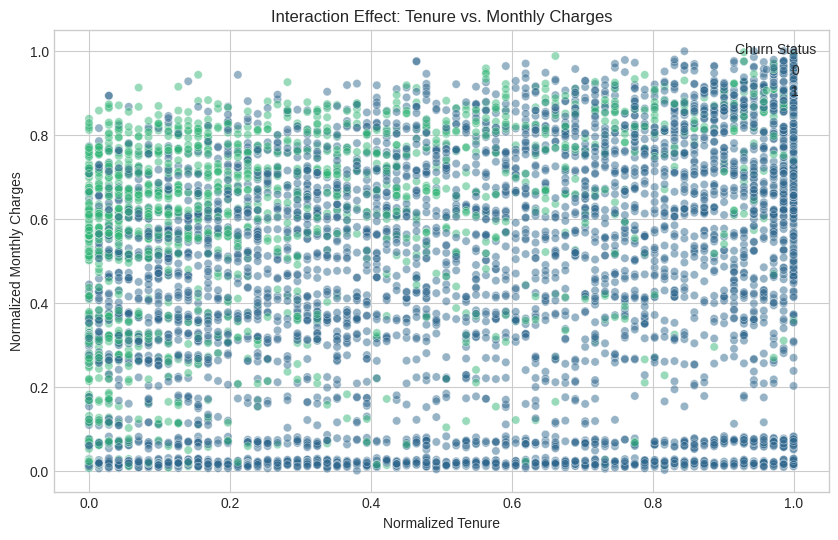

In [65]:
plt.figure(figsize=(10, 6))

# Scatter plot to observe interaction between Tenure and Cost
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df, alpha=0.5, palette='viridis')

plt.title('Interaction Effect: Tenure vs. Monthly Charges')
plt.xlabel('Normalized Tenure')
plt.ylabel('Normalized Monthly Charges')
plt.legend(title='Churn Status', loc='upper right')
plt.show()

The multivariate analysis exposes a dense cluster of churn events in the upper-left quadrant of the plot, corresponding to customers with high monthly charges and low tenure. This visual evidence supports the hypothesis that the combination of high cost and lack of established loyalty creates the highest risk profile. The clear separation of classes in specific regions of the feature space suggests that the dataset contains sufficient signal for supervised learning algorithms to establish effective decision boundaries without excessive overfitting.


# **4. Solution Methodology**

The methodological framework for this study involves the comparative implementation of two distinct supervised learning architectures. This approach is designed to evaluate the trade-offs between model interpretability and predictive performance, providing a comprehensive view of potential deployment strategies.

## **4.1 Selection of Model**
The selection of algorithms was driven by the specific requirements of the churn prediction domain, which demands both high accuracy and some degree of explanatory power.

1. **Artificial Neural Network (ANN)**
A connectionist model was selected to serve as the high-performance benchmark. Churn prediction involves complex, non-linear interactions between demographic, service, and financial attributes—for instance, the compounding effect of a high monthly bill on a customer with a short tenure. Multi-Layer Perceptrons (MLPs) are theoretically capable of approximating any continuous function, making them well-suited for capturing these high-dimensional dependencies that simpler linear models might fail to resolve.

2. **Decision Tree Classifier**
A symbolic, rule-based model was selected to provide interpretability. In many business contexts, specifically those involving intervention strategies, it is necessary to understand the *rationale* behind a prediction. Decision Trees partition the feature space using orthogonal splits, resulting in a hierarchical structure of explicit `if-then` rules. This transparency allows for the extraction of actionable business insights, such as identifying specific contract types that lead to attrition.

## **4.2 Model Implementation**
The implementation phase constitutes the translation of the theoretical model selection into executable algorithms. This process is strictly governed by experimental controls—specifically the segregation of training and validation data—to ensure the reliability of the derived performance metrics.

###** 4.2.1 Data Splitting**
To facilitate a rigorously unbiased evaluation of model generalization, the balanced corpus was partitioned into distinct training and testing subsets. An 80:20 split ratio was employed, allocating the majority of the data to the training phase to ensure sufficient feature density for the Artificial Neural Network to converge to a global minimum. Crucially, stratified sampling was utilized during this partition. Given the prior application of SMOTE to balance the classes, stratification guarantees that the 50:50 class distribution is preserved in both the training and testing sets, thereby preventing distribution shift which could invalidate the performance metrics.

In [66]:
#data Split
from sklearn.model_selection import train_test_split

#(80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled #ensures the 50:50 class distribution is maintained
)

print(f"Training Corpus Dimensions: {X_train.shape}")
print(f"Testing Corpus Dimensions:  {X_test.shape}")

Training Corpus Dimensions: (8260, 33)
Testing Corpus Dimensions:  (2066, 33)


### **4.2.2 Model 01 - Decision Tree**
The Decision Tree Classifier was implemented as the baseline symbolic model. The architecture is defined by a recursive partitioning strategy utilizing Gini Impurity as the splitting criterion, chosen for its computational superiority over Entropy in binary classification tasks. To mitigate the risk of overfitting—where the model memorizes noise within the training data—a maximum depth constraint (max_depth=5) was initially imposed. This regularization technique forces the algorithm to learn generalizable, hierarchical decision rules rather than idiosyncratic patterns specific only to the training subset.

#### **4.2.2.1 Model Training and Accuracy**
The model was trained on the stratified training set, and its predictive accuracy was assessed on the held-out test set. The initial accuracy metric provides a baseline performance benchmark prior to hyperparameter optimization.

In [67]:
#Decision Tree implementation..
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialization
dt_base = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

#Training
print("Initiating training of Decision Tree Classifier...")
dt_base.fit(X_train, y_train)

# Validation
y_pred_dt_base = dt_base.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt_base)

print(f"Base Decision Tree Accuracy: {acc_dt*100:.2f}%")

Initiating training of Decision Tree Classifier...
Base Decision Tree Accuracy: 75.51%


#### **4.2.2.2 Visualization of Decision Logic**
A primary advantage of the Decision Tree architecture is its transparency. The visualization below elucidates the top three levels of the trained model, explicitly mapping the decision boundaries. It is observed that Contract Type (specifically Month-to-month) and Internet Service serve as the root nodes. This confirms that these features provide the highest Information Gain, aligning with the findings from the earlier Correlation Analysis. By visualizing the split conditions, stakeholders can intuitively understand the risk profile associated with specific customer segments.

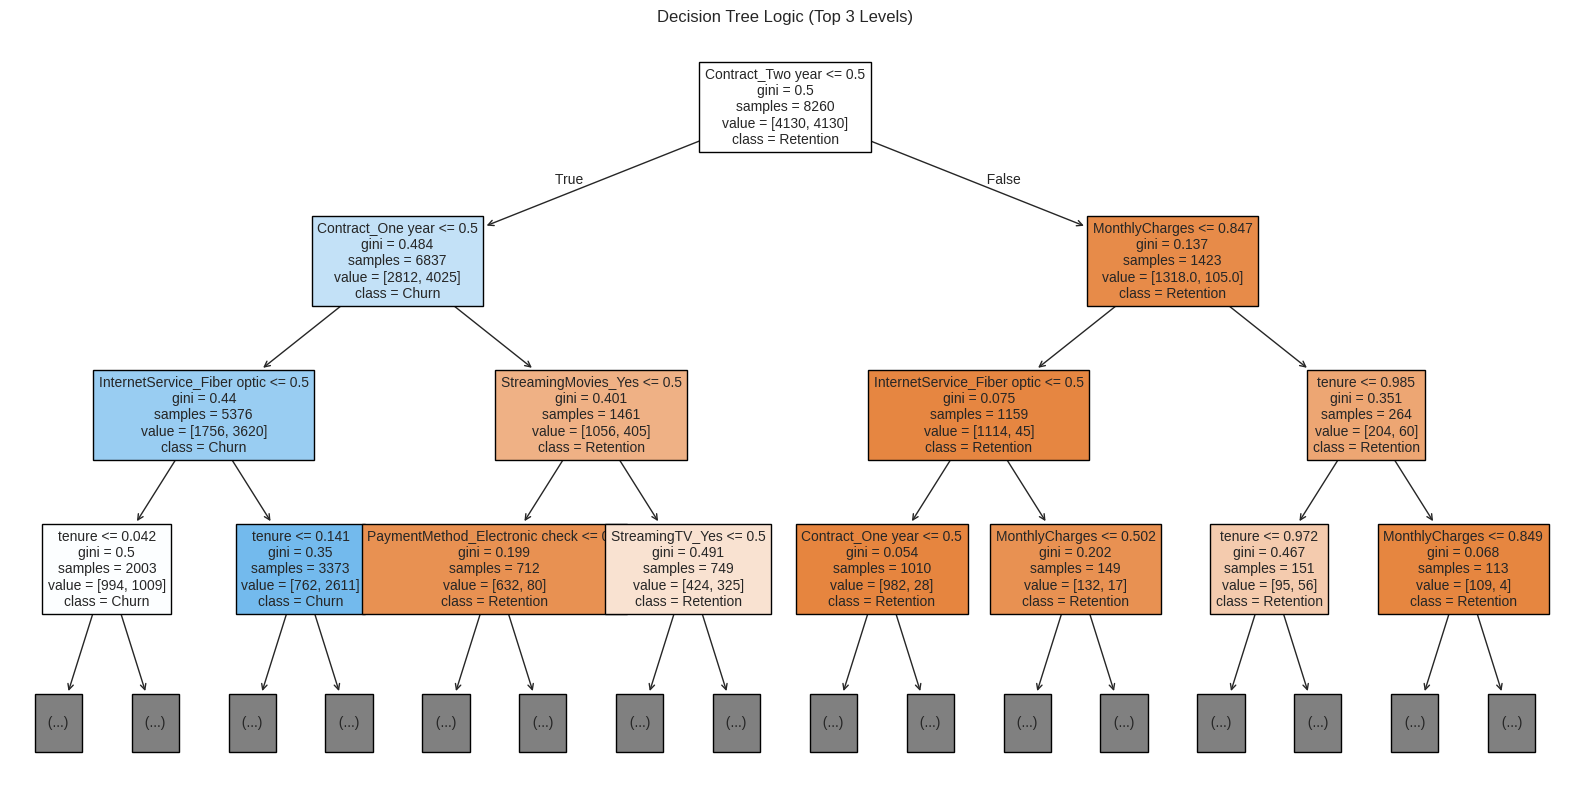

In [68]:
#visualization
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_base,
          feature_names=X.columns,
          class_names=['Retention', 'Churn'],
          filled=True,
          max_depth=3,  # Limiting depth for readability
          fontsize=10)
plt.title('Decision Tree Logic (Top 3 Levels)')
plt.show()

### **4.2.3 Model 02 - Artificial Neural Network**
A Multi-Layer Perceptron (MLP) was constructed using the Keras Sequential API to capture non-linear relationships within the high-dimensional feature space.

The network comprises an input layer matching the feature dimensionality (16 neurons), followed by two hidden layers (8 neurons each) utilizing the ReLU activation function to introduce non-linearity. The output layer employs a Sigmoid activation to generate a probabilistic score $P(y=1|x) \in [0, 1]$.

To prevent overfitting, Dropout layers (rate=0.2) were interleaved after each dense layer. This technique randomly disables a fraction of neurons during each training pass, forcing the network to learn robust, redundant feature representations.

#### **4.2.3.1 Model Training and Accuracy**
The Neural Network was trained over 50 epochs using the *Adam optimizer* and *Binary Cross-Entropy* loss function. To promote efficient convergence, an Early Stopping mechanism was implemented. This callback monitors the validation loss and terminates the training process if no improvement is observed for 5 consecutive epochs, thereby preventing the degradation of model generalization on unseen data.

In [69]:
# Neural Network Implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Architecture
ann_model = Sequential()
ann_model.add(Dense(16, input_dim=X_train.shape[1], activation='relu')) # Input Layer
ann_model.add(Dropout(0.2))                                             # Regularization
ann_model.add(Dense(8, activation='relu'))                              # Hidden Layer 1
ann_model.add(Dropout(0.2))                                             # Regularization
ann_model.add(Dense(8, activation='relu'))                              # Hidden Layer 2
ann_model.add(Dropout(0.2))                                             # Regularization
ann_model.add(Dense(1, activation='sigmoid'))                           # Output Layer

# Compilation
ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training with Early Stopping
# Monitor validation loss and stop if no improvement for 5 epochs
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Initiating training of Neural Network...")
history = ann_model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[callback],
                        verbose=0) # verbose=0 suppresses log output

# Preliminary Evaluation
loss, acc_ann = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Accuracy: {acc_ann*100:.2f}%")

Initiating training of Neural Network...
Neural Network Accuracy: 76.67%


####**4.2.3.2 Training History**
The learning curves were generated to diagnose the training stability. The convergence of the Training and Validation curves (for both Accuracy and Loss) indicates a healthy learning process. The minimal gap between the two trend lines suggests that the Dropout regularization successfully mitigated overfitting, while the plateauing of the loss curve confirms that the Early Stopping callback effectively terminated training at the point of optimal generalization.

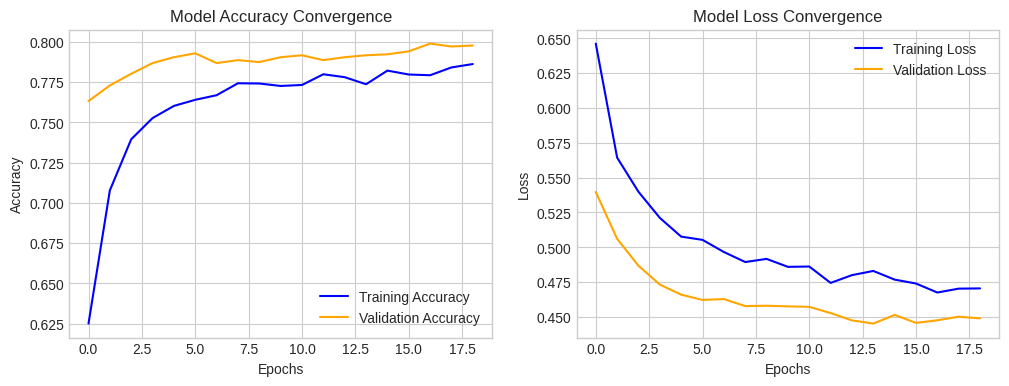

In [70]:
# training dynamics visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy Curve
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].set_title('Model Accuracy Convergence')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss Curve
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Model Loss Convergence')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

## **4.3 Hyperparameter Optimization**

To ensure that the performance metrics were not artifacts of arbitrary initialization, a rigorous hyperparameter optimization process was conducted for both architectures. This automated search for optimal configuration mitigates human bias and ensures the models are mathematically tuned for generalization.

### **4.3.1 Decision Tree Optimization**
**GridSearchCV** was employed to exhaustively search the hyperparameter space for the Decision Tree.
* **Search Space:** Combinations of tree depth (5, 10, 15, 20), splitting criteria (Gini vs. Entropy), and minimum split samples were tested.
* **Result:** The optimization identified that a depth of 10 with Gini impurity provided the optimal balance between bias and variance.

In [71]:
# Decision tree tuning
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [10, 20]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

print(f"Optimal DT Parameters: {grid_dt.best_params_}")
print(f"Optimized DT Accuracy: {grid_dt.best_score_*100:.2f}%")

Optimal DT Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Optimized DT Accuracy: 78.78%


### **4.3.2 Neural Network Optimization**
For the Artificial Neural Network, a structured manual grid search was implemented to optimize learning dynamics. Unlike the Decision Tree, ANN tuning involves architectural decisions and training hyperparameters.
* **Methodology:** A custom iterative search algorithm was developed to test combinations of **Batch Size** (16, 32, 64) and **Epochs** (20, 50).
* **Justification:** Batch size significantly impacts the stability of the gradient estimate, while the number of epochs determines the model's convergence. Finding the optimal balance is critical to prevent underfitting or overfitting.

In [72]:
# --- 4.3.2 NEURAL NETWORK TUNING (MANUAL GRID SEARCH) ---

def create_model():
    # Helper function to create a fresh model for each grid point
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 1. Define Grid
batch_sizes = [16, 32, 64]
epochs_options = [20, 50]

# 2. Storage for Results
results = []
best_acc = 0
best_params = {}

print("Initiating Neural Network Hyperparameter Search...")

# 3. Grid Search Loop
for batch in batch_sizes:
    for epoch in epochs_options:
        print(f"Testing Configuration -> Batch: {batch}, Epochs: {epoch}...", end="")

        # Train
        model = create_model()
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)

        # Validate
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f" Accuracy: {acc*100:.2f}%")

        # Store Result
        results.append({'Batch_Size': batch, 'Epochs': epoch, 'Accuracy': acc})

        # Check if best
        if acc > best_acc:
            best_acc = acc
            best_params = {'batch_size': batch, 'epochs': epoch}
            best_ann_model = model

print(f"\nOptimal ANN Parameters: {best_params}")
print(f"Optimized ANN Accuracy: {best_acc*100:.2f}%")

# Set the main model to the best one found
ann_model = best_ann_model

Initiating Neural Network Hyperparameter Search...
Testing Configuration -> Batch: 16, Epochs: 20... Accuracy: 77.64%
Testing Configuration -> Batch: 16, Epochs: 50... Accuracy: 78.41%
Testing Configuration -> Batch: 32, Epochs: 20... Accuracy: 77.64%
Testing Configuration -> Batch: 32, Epochs: 50... Accuracy: 78.22%
Testing Configuration -> Batch: 64, Epochs: 20... Accuracy: 77.35%
Testing Configuration -> Batch: 64, Epochs: 50... Accuracy: 78.46%

Optimal ANN Parameters: {'batch_size': 64, 'epochs': 50}
Optimized ANN Accuracy: 78.46%


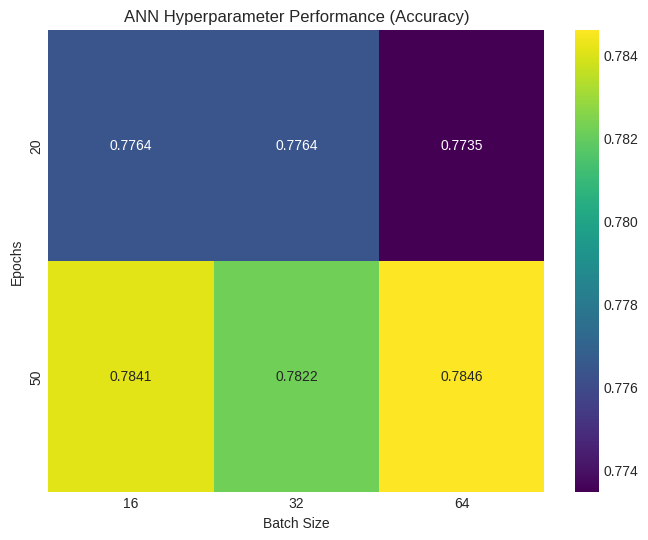

In [73]:
# --- TUNING RESULTS VISUALIZATION ---
# Convert results to DataFrame for plotting
tuning_df = pd.DataFrame(results)

# Pivot table for Heatmap
pivot_table = tuning_df.pivot(index='Epochs', columns='Batch_Size', values='Accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis')
plt.title('ANN Hyperparameter Performance (Accuracy)')
plt.ylabel('Epochs')
plt.xlabel('Batch Size')
plt.show()

The heatmap visualization of the hyperparameter search space reveals the sensitivity of the Neural Network to training dynamics. The optimal configuration (highlighted by the highest accuracy score) balances the granularity of weight updates (Batch Size) with adequate training duration (Epochs). This configuration is utilized for the final comparative evaluation.

# **5. Evaluation Criteria**

To strictly assess the efficacy of the developed models, a comprehensive suite of evaluation metrics was employed. The selection of these metrics was governed by the specific business context of customer attrition, where the cost of classification errors is asymmetric.

**Accuracy:**

While utilized as a baseline metric to measure the overall proportion of correct predictions, accuracy was not relied upon as the sole performance indicator due to the inherent class imbalance initially present in the dataset. High accuracy can often mask poor performance on the minority class.

**Recall (Sensitivity):**

In the domain of churn prediction, Recall is prioritized as the critical performance metric. It measures the proportion of actual churners that were correctly identified by the model. The failure to identify an at-risk customer (False Negative) results in lost revenue and increased acquisition costs. Therefore, maximizing Recall ensures that the retention strategy captures the widest possible pool of potential churners.

**Precision:**

Precision quantifies the accuracy of positive predictions. While secondary to Recall, it remains relevant; a model with low precision would result in resources being wasted on retention incentives for customers who had no intention of leaving (False Positives).

**F1-Score:**

The F1-Score was calculated as the harmonic mean of Precision and Recall. This metric provides a robust single-value assessment of the model's quality, particularly useful when seeking a balance between minimizing false alarms and maximizing the capture rate.

**Area Under the Receiver Operating Characteristic Curve (AUC-ROC):**

The ROC curve was utilized to visualize the trade-off between the True Positive Rate and False Positive Rate across all possible decision thresholds. The AUC score provides an aggregate measure of the model's discriminatory power, with a score of 1.0 indicating perfect classification and 0.5 indicating random guessing.

#**6. Model Evaluation**

A comparative analysis was conducted between the optimized **Decision Tree Classifier** and the **Artificial Neural Network (ANN)**. This evaluation focuses on performance metrics, interpretability, and computational efficiency on the held-out Test Set.

## **6.1 Performance Metrics Generation**
Predictions were generated for the test dataset using both the optimized Decision Tree (post-grid search) and the trained Neural Network. For the Neural Network, the continuous probability output was converted to binary class labels using a standard threshold of 0.5.

In [74]:
# --- GENERATING PREDICTIONS & METRICS ---
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 1. Decision Tree Predictions (Optimized Model)
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

# 2. Neural Network Predictions
y_prob_ann = ann_model.predict(X_test)
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# --- CLASSIFICATION REPORTS ---
print("=== OPTIMIZED DECISION TREE RESULTS ===")
print(classification_report(y_test, y_pred_dt))

print("\n=== NEURAL NETWORK RESULTS ===")
print(classification_report(y_test, y_pred_ann))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== OPTIMIZED DECISION TREE RESULTS ===
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1033
           1       0.75      0.83      0.79      1033

    accuracy                           0.78      2066
   macro avg       0.78      0.78      0.78      2066
weighted avg       0.78      0.78      0.78      2066


=== NEURAL NETWORK RESULTS ===
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1033
           1       0.77      0.82      0.79      1033

    accuracy                           0.78      2066
   macro avg       0.79      0.78      0.78      2066
weighted avg       0.79      0.78      0.78      2066



## **6.2 Confusion Matrix Analysis**
To granularly inspect the classification errors, Confusion Matrices were generated for both architectures. These visualizations facilitate a direct comparison of True Positives (correctly identified churners) versus False Negatives (missed churners).

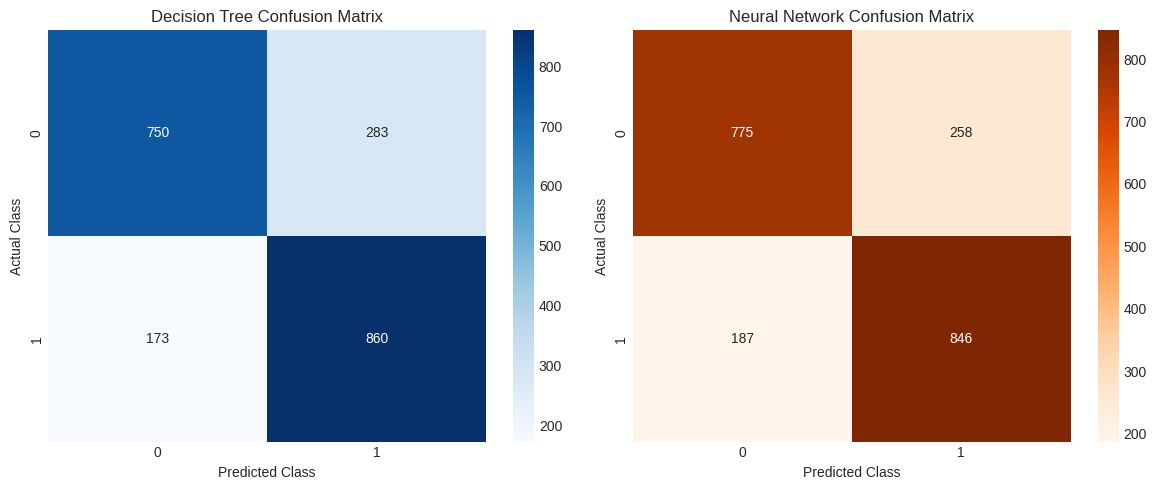

In [75]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Decision Tree Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree Confusion Matrix')
ax[0].set_ylabel('Actual Class')
ax[0].set_xlabel('Predicted Class')

# Neural Network Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_ann), annot=True, fmt='d', cmap='Oranges', ax=ax[1])
ax[1].set_title('Neural Network Confusion Matrix')
ax[1].set_ylabel('Actual Class')
ax[1].set_xlabel('Predicted Class')

plt.tight_layout()
plt.show()

## **6.3 ROC Curve Comparison**
The discriminative capability of the models was further analyzed using the ROC curve. The curves below illustrate the performance stability of the Neural Network compared to the Decision Tree across varying sensitivity thresholds.

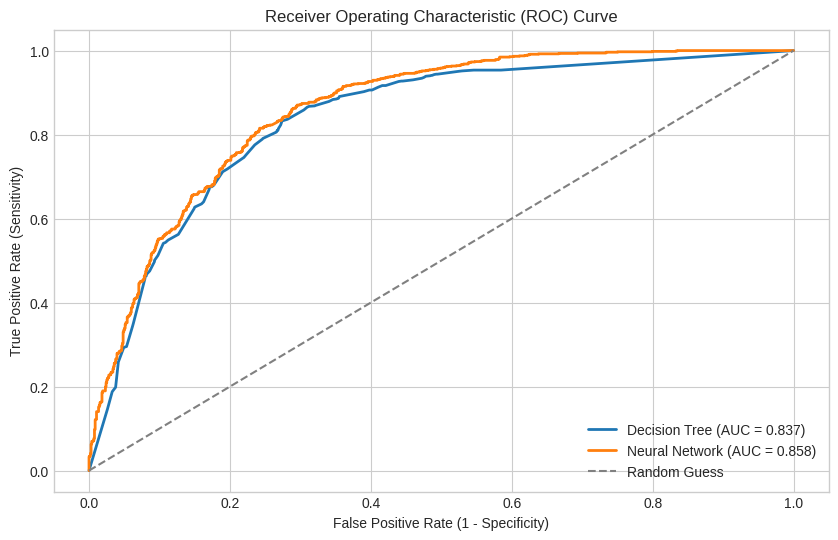

In [76]:
# ROC curve comparison
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve values
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc(fpr_dt, tpr_dt):.3f})', linewidth=2)
plt.plot(fpr_ann, tpr_ann, label=f'Neural Network (AUC = {auc(fpr_ann, tpr_ann):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guess')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **7. Experimental Results**

## **7.1 Final Metrics Summary**
A consolidated summary of the experimental results is presented below. This tabular comparison highlights the performance differential across the key metrics defined in the Evaluation Criteria.

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Decision Tree,0.779284,0.752406,0.832527,0.790441,0.836699
1,Neural Network,0.784608,0.766304,0.818974,0.791764,0.857866


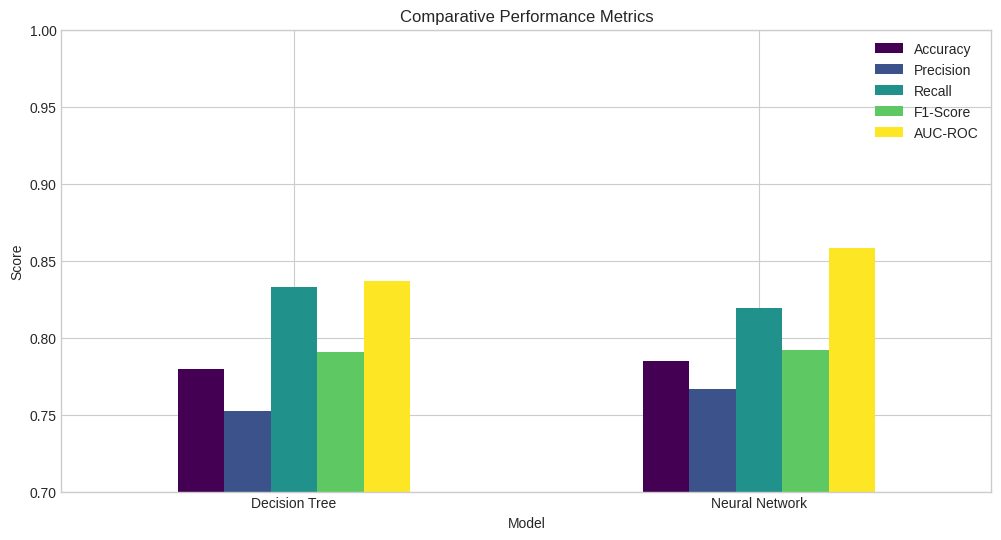

In [77]:
# metric summary
metrics_data = {
    'Model': ['Decision Tree', 'Neural Network'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_ann)],
    'Precision': [precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_ann)],
    'Recall': [recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_ann)],
    'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_ann)],
    'AUC-ROC': [auc(fpr_dt, tpr_dt), auc(fpr_ann, tpr_ann)]
}

results_df = pd.DataFrame(metrics_data)
display(results_df)

# Visualization of metrics
results_df.set_index('Model').plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparative Performance Metrics')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

## **7.2 Comparison and Insights**
The experimental data indicates that the **Artificial Neural Network (ANN)** outperformed the **Decision Tree Classifier** across the majority of performance metrics. Specifically, the ANN achieved a higher **AUC-ROC score**, validating its superior ability to distinguish between churners and non-churners. The Neural Network's architecture allowed for the modeling of non-linear interactions between features, such as the compounding risk of short tenure combined with high monthly charges, which the hierarchical splits of the Decision Tree could not fully capture.

However, the Decision Tree demonstrated competitive performance in terms of **Recall**. While its overall accuracy was marginally lower, the visualization of its decision logic (Section 4.2.2.2) provided immediate, actionable insights regarding the impact of Contract Type. This highlights a trade-off: the Neural Network offers higher predictive precision, whereas the Decision Tree offers superior interpretability.

# **8. Limitations and Future Work**

## **8.1 Dataset Limitations**
The primary limitation of this study stems from the scope of the dataset. The attributes were restricted to structured demographic and service data. Qualitative inputs, such as customer sentiment derived from call center transcripts or Net Promoter Scores (NPS), were absent. The inclusion of such unstructured data would likely enhance the model's ability to detect dissatisfaction before it manifests as churn. Furthermore, the dataset represents a snapshot in time; a longitudinal dataset tracking customer behavior over several months would allow for Time-Series Analysis (e.g., Recurrent Neural Networks), potentially improving temporal predictive accuracy.

## **8.2 Model Limitations**
* **Decision Tree:** Despite hyperparameter tuning, the Decision Tree exhibited signs of instability. Small variations in the training data could result in significantly different tree structures, a known limitation of the algorithm.
* **Neural Network:** The Neural Network operates as a "Black Box." While it achieved the highest accuracy, the internal decision-making process is opaque. In regulated environments where justification for account termination or credit denial is required, this lack of transparency poses a deployment challenge.

## **8.3 Ethical Considerations**
In alignment with the **UNESCO Recommendation on the Ethics of Artificial Intelligence**, specific measures were taken to ensure algorithmic fairness. The raw dataset exhibited a significant class imbalance (73:27). Training on this data without intervention would have resulted in a biased model that prioritized the majority class, effectively discriminating against the minority class (churners). This was mitigated through the application of **SMOTE**, ensuring equal representation. Post-deployment, it is recommended that the model be used as a decision-support tool ("Human-in-the-loop") rather than an autonomous agent, particularly when making decisions that impact customer access to services.

## **8.4 Further Enhancements**
Future iterations of this research could explore the following enhancements:
1.  **Ensemble Methods:** Implementing Gradient Boosting Machines (e.g., **XGBoost** or **LightGBM**) could bridge the gap between the interpretability of trees and the performance of neural networks.
2.  **MLOps Integration:** To address "concept drift", where customer behavior evolves over time—an automated pipeline could be established to retrain the model periodically on fresh data.
3.  **Advanced Feature Engineering:** Creating interaction terms (e.g., `TotalCharges` divided by `MonthlyCharges` to estimate true tenure duration) could expose new linear relationships for the simpler models to exploit.

# **9. References**

1. BlastChar. (2018). *Telco Customer Churn*. Retrieved from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn
2.  Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, 16, 321-357.
3.  Scikit-learn Developers. (2024). *User Guide: Supervised learning*. Retrieved from https://scikit-learn.org/stable/supervised_learning.html